# Reconocimiento de marcadores en una escena
### y su reemplazo por una imagen sustituto puesta en perspectiva y posicionamiento de una nube de puntos

Notebook demo de la estrategia propuesta


In [1]:
#dependencias:
import cv2
from matplotlib import pyplot as plt
import math
#funciones para reconocer y reemplazar glifos en una escena
import ar_functions as ar
#funciones utilziadas para el manejo de una nube de puntos
import point_cloud_functions as pc
#base de datos de los glifos y los objetos de AR que representan
import glyph_database as db


In [2]:
#umbral de luminancia para considerar a un pixel como negro
BLACK_THRESHOLD = 100
#umbral de luminancia para considerar a un pixel como blanco
WHITE_THRESHOLD = 155
#máxima cantidad de glifos en una escena
GLYPHS_ON_THE_SCENE = 10

Esta demostración permite reemplazar glifos en la escena por imágenes .png o nubes de puntos. Para facilitar el manejo de la nube de puntos se decidió copiar la información de los vértices de un archivo .obj (que se puede abrir en formato ASCII) en un archivo .txt. 

El diccionario __GLYPH_TABLE__ hallado en el archivo *glyph_database.py* funciona sólo para asociar los códigos binarios de los glifos con los objetos de realidad aumentada que les corresponden. Previo al análisis de la escena, se cargan los archivos en memoria. Las operaciones más costosas son las relacionadas al manejo de la nube de puntos.



In [3]:
#diccionario a cargar con imagenes y nubes de puntos
glyphs_data = {}

#se lee db.GLYPH_TABLE y se cargan los archivos indicados
for (label,kind) in db.GLYPH_TABLE.values() :
    if kind == "image" : 
        glyphs_data[label] = cv2.imread('{}.png'.format(label))
    elif kind == "point_cloud" :
        cloud = pc.text2cloud('{}.txt'.format(label) )
        #rotación arbitraria
        cloud = pc.rotate_y( cloud, math.pi/2)
        cloud = pc.rotate_z( cloud, math.pi/2)
        glyphs_data[label] = cloud

A continuación se implementa una funcion auxiliar para visualizar los resultados en este notebook. 

In [4]:
def show_image(image):
    #si la imagen tiene 3 canales:
    if len( image.shape ) == 3 : 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cmap = None
    #si la imagen tiene 1 canal (no se trabaja con imagenes de otra cantidad de canales):
    else : 
        cmap = "gray"
        
    plt.axis("off")    
    plt.imshow(image, cmap = cmap)
    plt.show()
    
#configuración de figuras en el notebook
side = 20
%matplotlib inline
plt.rcParams['figure.figsize'] = [side, side]

Se lee la imagen de la escena y se obtiene una version en escala de grises para hacer el análisis.

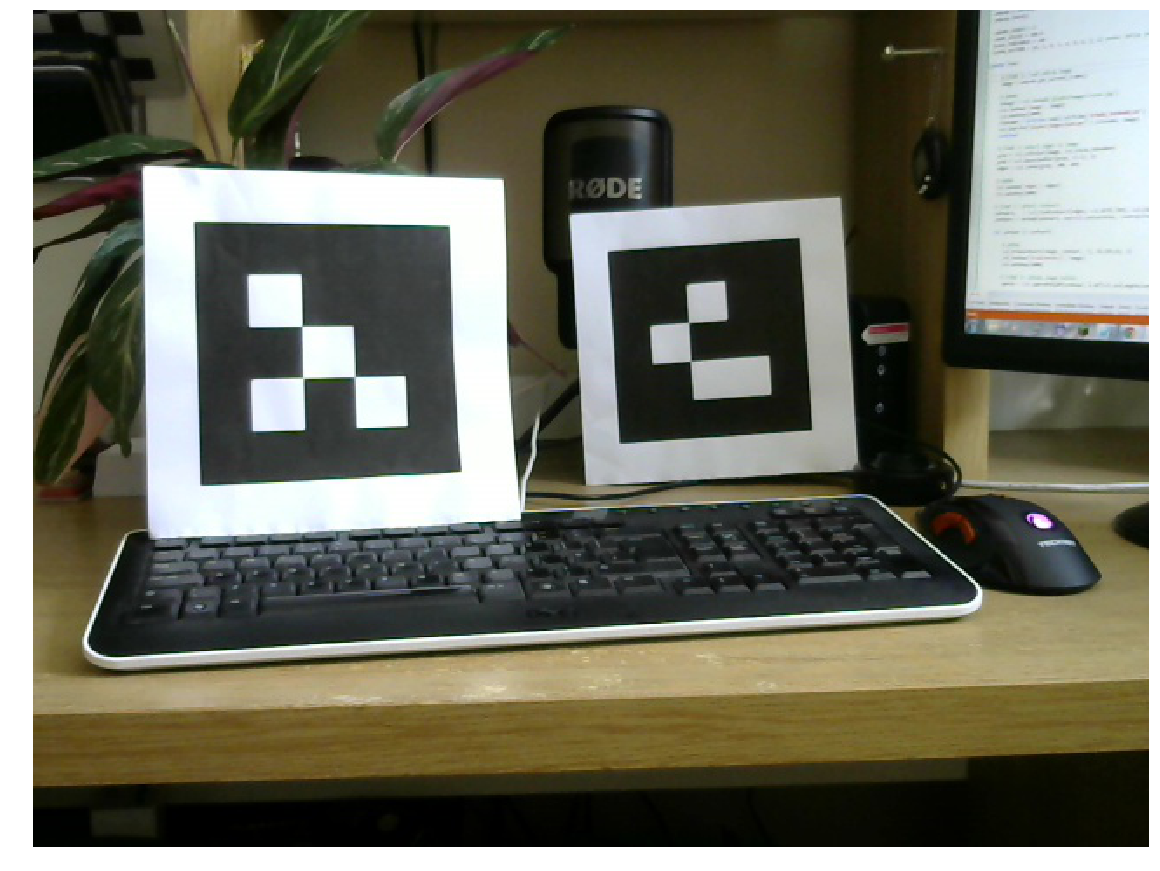

In [5]:
img = cv2.imread('glyph_scene.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(img)

Se desean reconocer los cuadrilateros de la escena, que son los candidatos a glifos para reemplazar. Para esto se debe tener información de los bordes detectados en la escena (calculados con cv2.Canny). Previamente a la detección de bordes se hace un blur de la escena con cv2.GaussianBlur.

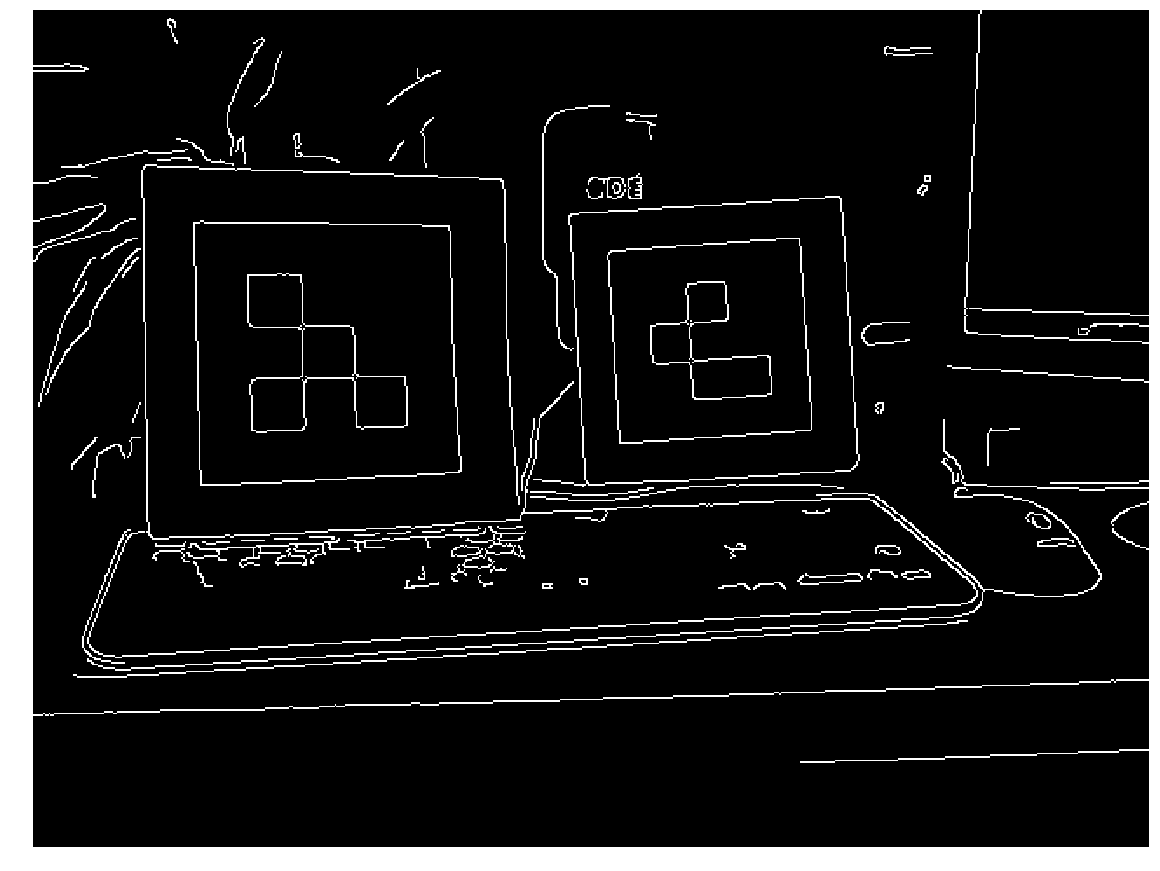

In [6]:
blur = cv2.GaussianBlur(gray, (5,5), 0)
edges = cv2.Canny(blur, 100, 200)
show_image(edges)

Con la función cv2.findContours se buscan los contornos cerrados presentes en la escena y sólo se analizan los 10 contornos con mayor área.

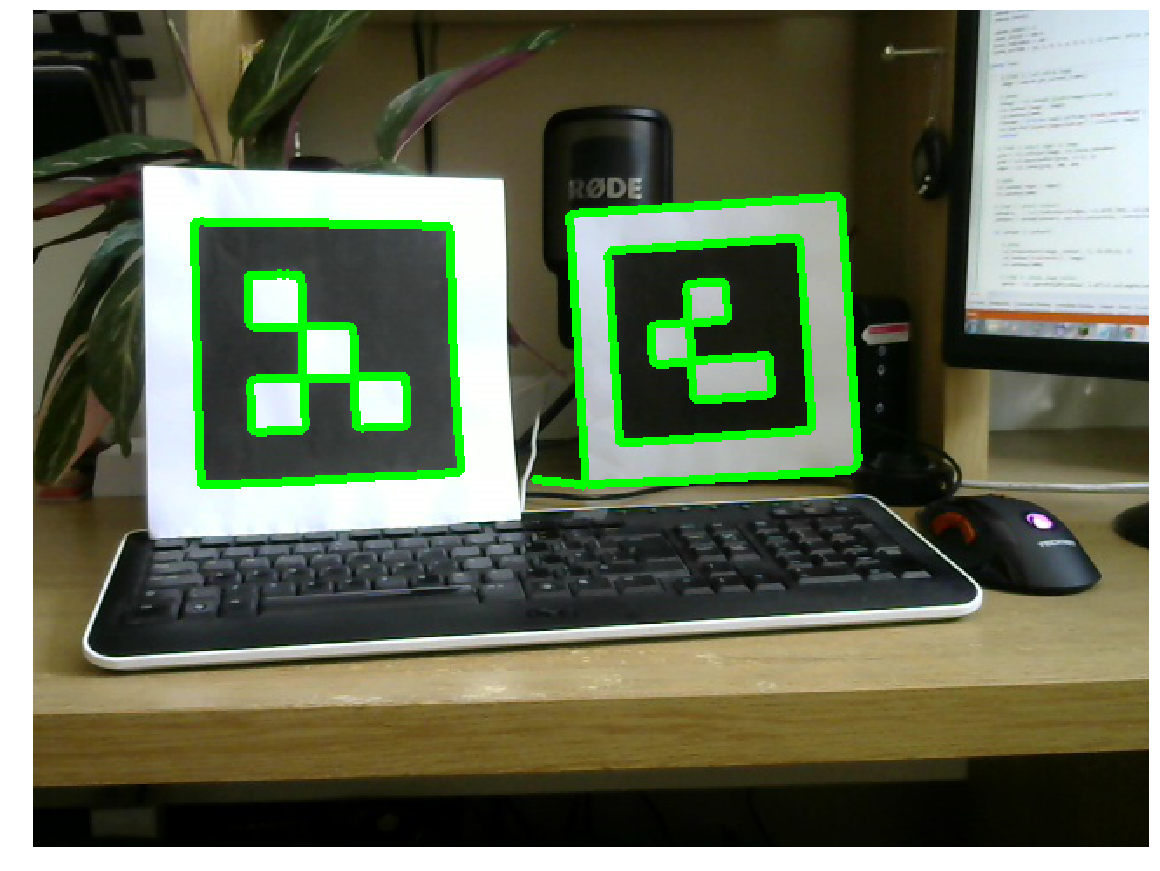

In [7]:
_, contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse=True)[:GLYPHS_ON_THE_SCENE]
img_w_edges = img.copy()
cv2.drawContours(img_w_edges, contours, -1, (0,255,0), 3)
show_image(img_w_edges)

Sólo interesa analizar los contornos que tienen 4 lados (como los marcadores posibles). A estos contornos se les es aplicada una transformación de perspectiva para poder tener una vista frontal y facilitar su análisis.

In [8]:
#lista a llenar con contornos cuadrilateros
quads = []

#se recorre la lista de contornos
for i,contour in enumerate(contours):  
    #se analiza el peremitro y la cantidad de vertices del contorno
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.01*perimeter, True)

    #se agrega el contorno a la lista quads si este tiene 4 lados.
    #ya que cv2.findContours puede encontrar contornos duplicados pero con orientación diferente,
    #se utiliza el signo del resultado de cv2.contourArea para sólo quedarse con un contorno posible
    if (len(approx) == 4) and (cv2.contourArea(contour,True) > 0):
        #se redimensiona el arreglo de vértices para que tenga 4 elementos de la forma x,y
        approx = approx.reshape(4, 2)
        #transformación de perspectiva
        topdown_quad = ar.get_topdown_quad(gray, approx)
        quads.append( [topdown_quad, approx] )



### Veamos los marcadores encontrados!

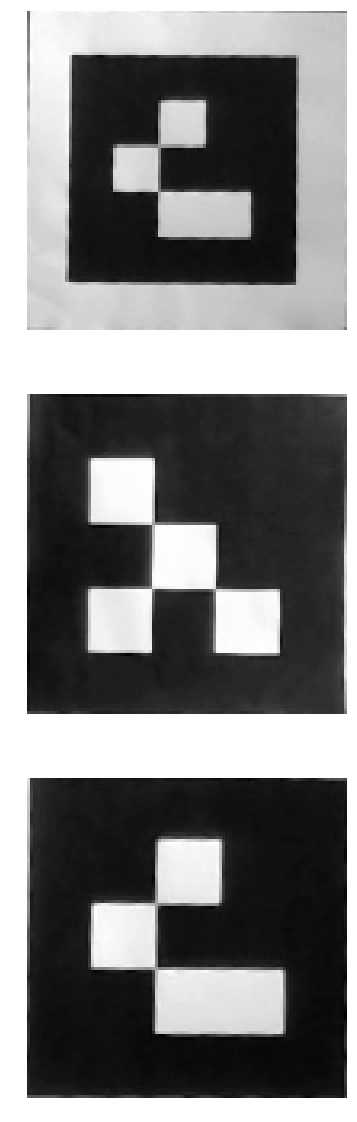

In [9]:
#se crea una figura con tantos cuadriláteros como los encontrados
rows = len(quads)
fig, axs = plt.subplots(rows)

#plot
for i, (quad, approx) in enumerate(quads) :
        axs[i].axis("off")
        axs[i].imshow(quad, cmap = "gray")
        
plt.show()

Por último, se verifica la validez de los glifos encontrados (es decir que poseen una frontera de celdas negras) y se hace el reemplazo en la escena

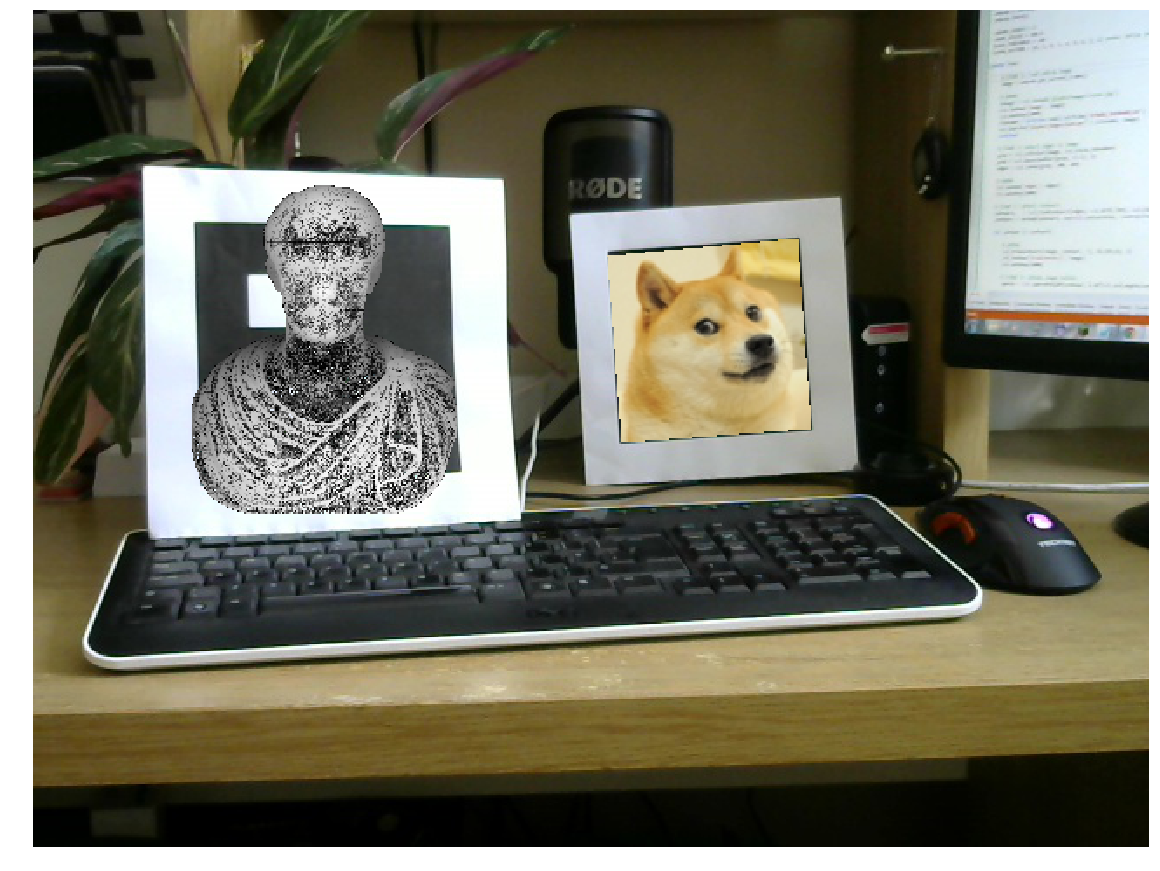

In [10]:
#Se recorre quads
for i, (quad, approx) in enumerate(quads):
    #se obtiene el código binario que representa esa imagen
    glyph_pattern = ar.get_glyph_pattern(quad, BLACK_THRESHOLD, WHITE_THRESHOLD)  
    #se verifica que el código binario represente un glifo
    valid_glyph = ar.is_valid_glyph(glyph_pattern)
    #si el código binario es válido:
    if (valid_glyph) :
        #se recortan las 5 celdas de la frontera
        glyph_code = [ row[1:ar.CELLS_IN_A_GLYPH-1] for row in glyph_pattern[1:ar.CELLS_IN_A_GLYPH-1] ]
        #se busca en la base de datos por qué se debe reemplazar el marcador
        glyph_found, (label, kind) = db.match_glyph_pattern(glyph_code)
        #si el marcador debe ser reemplazado:
        if glyph_found:
            #si se debe reemplazar por una imagen:
            if kind == "image" :
                img, dst_points  = ar.add_substitute_quad( img, glyphs_data[ label ], approx.reshape(4,2))
            #si se debe reemplazar por una nube de puntos:
            elif kind == "point_cloud" :
                img = ar.add_substitute_cloud(img, glyphs_data[ label ], approx.reshape(4,2)  )
            
show_image(img)     
    